In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import pandas as pd

import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Exemple de la dyspnée (Lauritzen & Spiegelhalter (88))

La **dyspnée** peut être engendrée par une **tuberculose**, un
**cancer des poumons**, une **bronchite**, par plusieurs de ces
maladies, ou bien par aucune.

Un séjour récent en **Asie** augmente les chances de tuberculose,
tandis que **fumer** augmente les risques de cancer des poumons.
Des **rayons X** permettent de détecter une tuberculose ou un
cancer.

Un patient éprouve des difficultés à respirer. Dans quelle mesure
peut-on dire qu'il est atteint de dyspnée?

# Générer une base de données depuis un RB

In [3]:
bn=gum.loadBN("res/asia.bif")
bn

(pyAgrum.BayesNet<double>@000001EBEC8E97A0) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 18, mem: 288o}

In [4]:
generator=gum.BNDatabaseGenerator(bn)
generator.setRandomVarOrder()
generator.drawSamples(500000)
generator.toCSV("out/sample_asia.csv")

#gum.genereteSample(...)

In [5]:
#import pyAgrum.lib._utils.oslike as oslike
data = pd.read_csv("out/sample_asia.csv")
print("===\n  Size of the generated database\n===")
data.shape

===
  Size of the generated database
===


(500000, 8)

In [6]:
print("\n===\n  First lines\n===")
data.head()


===
  First lines
===


,smoking,lung_cancer,bronchitis,positive_XraY,dyspnoea,tuberculosis,visit_to_Asia,tuberculos_or_cancer
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,0,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,0,0,0,1,1,1


In [7]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.names()

('visit_to_Asia',
 'tuberculosis',
 'tuberculos_or_cancer',
 'positive_XraY',
 'lung_cancer',
 'smoking',
 'bronchitis',
 'dyspnoea')

In [8]:
learner.idFromName('visit_to_Asia') # first row is 0

0

In [9]:
learner.nameFromId(4)

'lung_cancer'

# Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

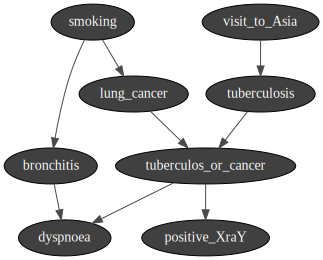

In [10]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables and labels
bn2 = gum.BayesNet(bn)
learner.fitParameters(bn2)
gnb.showBN(bn2)

In [11]:
print(learner)

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -



In [12]:
gnb.sideBySide(gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia'))), gnb.getPotential(bn2.cpt (bn2.idFromName('visit_to_Asia'))), 
                                gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis'))), gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis'))), 
                                captions=["Original BN", "Learned BN", "Original BN", "Learned BN"], ncols=2)

# Structural learning a BN from the database

## Different learning algorithms

### Tabulist

In [19]:
import pyAgrum.lib.explain as explain

In [20]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,explain.getInformation(bn2))
kl=gum.ExactBNdistance(bn,bn2)
kl.compute()

Learned in 454.9683ms


{'klPQ': 4.154374157795455e-05,
 'errorPQ': 0,
 'klQP': 3.923714551081084e-05,
 'errorQP': 128,
 'hellinger': 0.003872448797364239,
 'bhattacharya': 7.492316046024049e-06,
 'jensen-shannon': 1.0594150860398437e-05}

### GHC

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [ ]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,explain.getInformation(bn2))

### K2

And a K2 for those who likes it :)

In [15]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([0,1,2,3,4,5,6,7])
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Learned in 350.7488ms


(pyAgrum.BayesNet<double>@0000014259EC6C00) BN{nodes: 8, arcs: 9, domainSize: 256, dim: 19, mem: 304o}

K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [16]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([7,6,5,4,3,2,1,0])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Learned in 0.1555174s


(pyAgrum.BayesNet<double>@0000014259EC6060) BN{nodes: 8, arcs: 16, domainSize: 256, dim: 45, mem: 720o}

### MIIC

In [17]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useMIIC()
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Learned in 1.3478342s


(pyAgrum.BayesNet<double>@000001426A9181C0) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 18, mem: 288o}

# Following the learning curve

In [18]:
plt.style.use('ggplot')

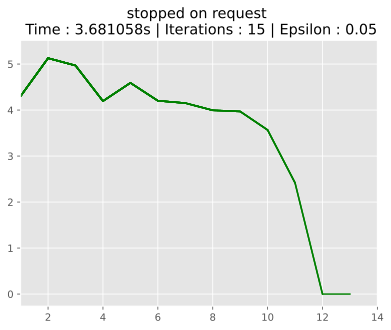

In [19]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 3 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


# Customizing the learning algorithms

## Learn a tree ?

In [20]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node

bntree=learner.learnBN()
bntree

(pyAgrum.BayesNet<double>@000001426A919330) BN{nodes: 8, arcs: 7, domainSize: 256, dim: 15, mem: 240o}

## With prior structural knowledge

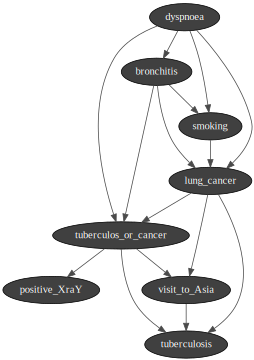

In [21]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc("smoking","lung_cancer") # smoking->lung_cancer
# I know that visit to Asia may change the risk of tuberculosis
learner.addMandatoryArc("visit_to_Asia","tuberculosis") # visit_to_Asia->tuberculosis

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")

## Comparing BNs

In [22]:
help(gnb.getBNDiff)

Help on function getBNDiff in module pyAgrum.lib.notebook:

getBNDiff(bn1, bn2, size=None, noStyle=False)
    get a HTML string representation of a graphical diff between the arcs of _bn1 (reference) with those of _bn2.
    
    if `noStyle` is False use 4 styles (fixed in pyAgrum.config) :
      - the arc is common for both
      - the arc is common but inverted in `bn2`
      - the arc is added in `bn2`
      - the arc is removed in `bn2`
    
    Parameters
    ----------
    bn1: pyAgrum.BayesNet
      the reference
    bn2: pyAgrum.BayesNet
      the compared one
    size: float|str
      size (for graphviz) of the rendered graph
    noStyle: bool
      with style or not.
    
    Returns
    -------
    str
      the HTML representation of the comparison



In [23]:
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
              captions=['target','learned BN','graphical diffs between target and learned'])

In [24]:
kl=gum.ExactBNdistance(bn,bn2)
kl.compute()

{'klPQ': 3.072950519510782e-05,
 'errorPQ': 0,
 'klQP': 2.8034020534617975e-05,
 'errorQP': 128,
 'hellinger': 0.0033440086674704117,
 'bhattacharya': 5.585570717585899e-06,
 'jensen-shannon': 7.844650621454519e-06}

## Changing the scores

By default, a BDEU score is used. But it can be changed.

In [25]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

klPQ :0.12242383421150209errorPQ :0klQP :0.03434255985551276errorQP :64hellinger :0.20431505155486523bhattacharya :0.02109322054763944jensen-shannon :0.024074212414897947distances


## Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [26]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

klPQ :2.6309920735936463e-05errorPQ :0klQP :2.3501254063202975e-05errorQP :128hellinger :0.0031008847460028527bhattacharya :4.8021127685575636e-06jensen-shannon :6.717897178457066e-06distances


And then we refine with tabuList

In [27]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
#learner.setMaxNbDecreasingChanges(2)

bn3=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn3)
gnb.sideBySide(bn3,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

klPQ :2.3515039871259283e-05errorPQ :0klQP :2.0758095508532784e-05errorQP :128hellinger :0.0029420813168430943bhattacharya :4.322288713047451e-06jensen-shannon :6.025678851997385e-06distances


# Impact of the size of the database for the learning

In [28]:
data.head()

,bronchitis,lung_cancer,dyspnoea,visit_to_Asia,tuberculosis,tuberculos_or_cancer,smoking,positive_XraY
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,0
4,1,1,1,1,1,1,1,0


In [29]:
import IPython.display
rows=3
sizes=[400,500,600,700,1000,1500,
       2000,2500,3000,5000,
       10000,50000,75000,
       100000,150000,
       200000,300000,500000]


In [30]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    data.sample(n=i, random_state=42).to_csv("out/extract_asia.csv")
    # oslike.rm("out/extract_asia.csv")
    # oslike.head("out/sample_asia.csv",n,"out/extract_asia.csv")
    # oslike.wc_l("out/extract_asia.csv")
    learner=gum.BNLearner("out/extract_asia.csv",bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    bn2=learner.learnBN()
    
    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"
IPython.display.display(IPython.display.HTML(res))

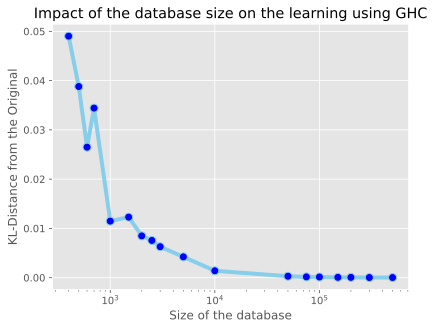

In [31]:
import matplotlib.pyplot as plt

plt.title("Impact of the database size on the learning using GHC")
plt.xlabel("Size of the database")
plt.ylabel("KL-Distance from the Original")
plt.xscale('log')
plt.plot(sizes, l, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=4)

In [32]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    data.sample(n=i, random_state=42).to_csv("out/extract_asia.csv")
    # oslike.rm("out/extract_asia.csv")
    # oslike.head("out/sample_asia.csv",n,"out/extract_asia.csv")
    # oslike.wc_l("out/extract_asia.csv")
    learner=gum.BNLearner("out/extract_asia.csv",bn) #using bn as template for variables
    learner.useLocalSearchWithTabuList()
    bn2=learner.learnBN()
    
    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    bn2.setProperty("name","BN(%{0})".format(i))
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

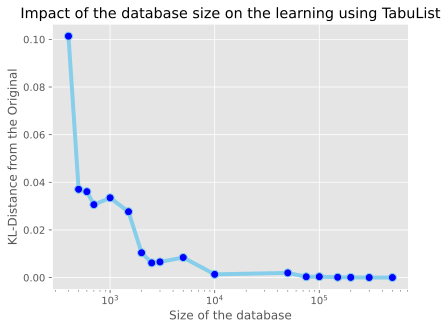

In [33]:
import matplotlib.pyplot as plt

plt.title("Impact of the database size on the learning using TabuList")
plt.xlabel("Size of the database")
plt.ylabel("KL-Distance from the Original")
plt.xscale('log')
plt.plot(sizes, l, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=4)